In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [3]:
import torch.nn.functional as F
from torch.nn import Linear
# 3*32*32
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,8,3, stride=2, padding=1),
            nn.Conv2d(8,16,3, stride=2, padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,8,2,2),
            nn.ConvTranspose2d(8,3,2,2),
            nn.Tanh(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded
    

class Autoencoder_linear(nn.Module):
    def __init__(self, n_enc_1, n_dec_1,
                 n_input, n_z):
        super(Autoencoder3, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            Linear(n_input, n_enc_1),
            nn.ReLU(),
            Linear(n_enc_1, n_z)
        )

        # decoder
        self.decoder = nn.Sequential(
            Linear(n_z, n_dec_1),
            nn.ReLU(),
            Linear(n_dec_1, n_input)
        )
            
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [4]:
X_train = np.load('./data/trainX.npy')
X_train = np.transpose(X_train,(0,3,1,2)) / 255.*2-1

In [6]:
train_dataloader = DataLoader(X_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(X_train, batch_size=32, shuffle=False)

model = Autoencoder()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
device = torch.device('cuda')
model = model.to(device)

model.train()
for epoch in tqdm(range(5)):
    for x in train_dataloader:
        x=x.float()
        x = x.to(device)
        latent, reconstruct = model(x)
        loss = criterion(reconstruct, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.07s/it]


In [22]:
# Retrive latent variables after encoder
model.eval()
latents = []
reconstructs = []
for x in test_dataloader:
    x=x.float()
    x = x.to(device)
    latent, reconstruct = model(x)
    latents.append(latent.cpu().detach().numpy())
    reconstructs.append(reconstruct.cpu().detach().numpy())

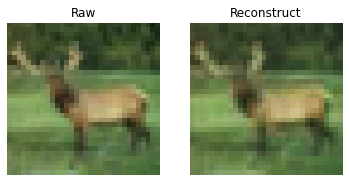

In [42]:
reconstructs = np.concatenate(reconstructs, axis=0)

plt.subplot(121)
tmp = (X_train[100] +1) * 255/2
plt.imshow(tmp.transpose((1,2,0)).astype(int))
plt.title('Raw')
plt.axis('off') 

plt.subplot(122)
tmp = (reconstructs[100] +1) * 255/2
plt.imshow(tmp.transpose((1,2,0)).astype(int))
plt.title('Reconstruct')
plt.axis('off') 

plt.show()

In [14]:
latents = np.concatenate(latents, axis=0)
latents = latents.reshape([9000,-1])
latents_mean = np.mean(latents, axis=0)
latents_std = np.std(latents, axis=0)
latents = (latents - latents_mean) / latents_std

In [17]:
# Encoder + PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
num_PCA = 32
latents_PCA = PCA(n_components=num_PCA).fit_transform(latents)
latents_PCA_tsne = TSNE(n_components=2).fit_transform(latents_PCA)

from sklearn.cluster import KMeans
result = KMeans(n_clusters = 2).fit(latents_PCA).labels_

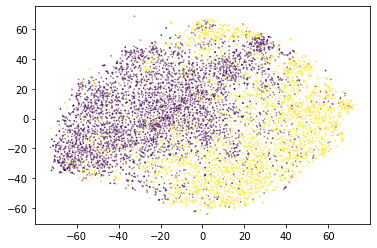

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

y_train = np.load('./data/trainY.npy')
plt.figure()
plt.scatter(latents_PCA_tsne[:,0],latents_PCA_tsne[:,1],c=y_train, s=0.5, alpha = 0.5)

plt.show()